<a href="https://colab.research.google.com/github/LeroyMichael/Big_Data_Processing/blob/master/Query_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
msnpc = spark.read.csv("/content/drive/My Drive/Query Visualization/MsNPC.csv", header = True, inferSchema=True)
msplayer = spark.read.csv("/content/drive/My Drive/Query Visualization/MsPlayer.csv", header = True, inferSchema=True)
msweapon = spark.read.csv("/content/drive/My Drive/Query Visualization/MsWeapon.csv", header = True, inferSchema=True)
msweapontype = spark.read.csv("/content/drive/My Drive/Query Visualization/MsWeaponType.csv", header = True, inferSchema=True)
transactiondetail = spark.read.csv("/content/drive/My Drive/Query Visualization/TransactionDetail.csv", header = True, inferSchema=True)
transactionheader = spark.read.csv("/content/drive/My Drive/Query Visualization/TransactionHeader.csv", header = True, inferSchema=True)
msnpc.createOrReplaceTempView("MsNPC")
msplayer.createOrReplaceTempView("MsPlayer")
msweapon.createOrReplaceTempView("MsWeapon")
msweapontype.createOrReplaceTempView("MsWeaponType")
transactiondetail.createOrReplaceTempView("TransactionDetail")
transactionheader.createOrReplaceTempView("TransactionHeader")

In [ ]:
res1 = spark.sql("SELECT WeaponTypeName , SUM(WeaponPrice * Quantity) as WeaponTypeSold from MsWeaponType wt join MsWeapon w on wt.WeaponTypeId = w.WeaponTypeId join TransactionDetail td on w.WeaponId = td.WeaponId join TransactionHeader th on td.TransactionId = th.TransactionId and year(TransactionDate) = 2019 GROUP BY WeaponTypeName order by WeaponTypeSold asc Limit 5")
res1 = res1.toPandas()

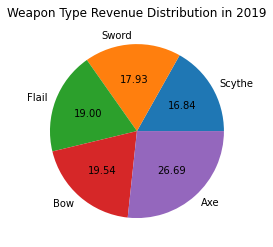

In [ ]:
#1 A
plt.title("Weapon Type Revenue Distribution in 2019")
plt.pie(res1["WeaponTypeSold"], labels=res1["WeaponTypeName"], autopct="%.2f")
plt.show()

In [ ]:
res2 = spark.sql("SELECT MONTH(TransactionDate) as Month, COUNT(DISTINCT(p.PlayerId)) as PlayerCount from TransactionHeader th JOIN MsPlayer p on th.PlayerId = p.PlayerId JOIN TransactionDetail td on th.TransactionId = td.TransactionId JOIN MsWeapon w on td.WeaponId = w.WeaponId JOIN MsWeaponType wt on w.WeaponTypeId = wt.WeaponTypeId WHERE WeaponTypeName = 'Axe' and YEAR(TransactionDate) = '2019' GROUP BY MONTH(TransactionDate) order by MONTH(TransactionDate)")
res2 = res2.toPandas()

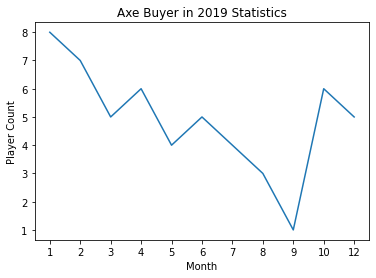

In [ ]:
#1 B
plt.title("Axe Buyer in 2019 Statistics")
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.plot(res2["PlayerCount"])
plt.xticks(range(len(res2["Month"])), res2["Month"])
plt.show()

In [ ]:
res3 = spark.sql("SELECT SpecialWeapon as SpecialWeapon, count(SpecialWeapon) as Frequency from(select mp.PlayerId,case when sum(WeaponPrice*Quantity) >2000000 then 'Extinction' when sum(WeaponPrice*Quantity) >=1500000 and sum(WeaponPrice*Quantity) <=1999999 then 'Nightfall' when sum(Weaponprice*Quantity)>=1000000 then 'Stormbreaker' end as SpecialWeapon from MsPlayer mp,TransactionHeader th, TransactionDetail td, MsWeapon mw where mp.PlayerId = th.PlayerId and th.TransactionId = td.TransactionId and td.WeaponId = mw.WeaponId and PlayerGender like 'Female' and year(TransactionDate) = 2019 group by mp.PlayerId, month (TransactionDate) order by sum(WeaponPrice*Quantity))as x group by SpecialWeapon having Frequency > 0 order by Frequency desc")
res3 = res3.toPandas()

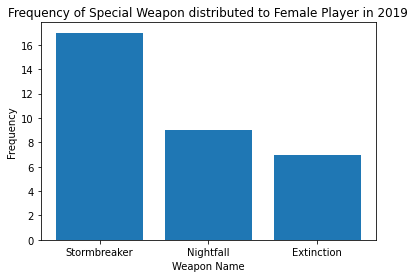

In [ ]:
plt.title("Frequency of Special Weapon distributed to Female Player in 2019")
plt.xlabel("Weapon Name")
plt.ylabel("Frequency")
plt.bar(res3["SpecialWeapon"],res3["Frequency"])
plt.show()

In [ ]:
res4 = spark.sql("select a.month as Month,count(distinct a.playerid) as TotalPlayer from(select a.playerid,month(b.transactiondate) as month,count(distinct d.weapontypeid) as weapontype from msplayer a join transactionheader b on a.playerid = b.playerid join transactiondetail c on b.transactionid = c.transactionid join msweapon d on c.weaponid = d.weaponid join msweapontype e on d.weapontypeid = e.weapontypeid where year(b.transactiondate) = 2019  group by a.playerid,month(b.transactiondate) having count(distinct e.weapontypeid) >= 3)a group by a.month order by a.month")
res4 = res4.toPandas()

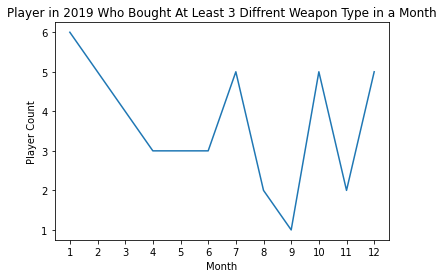

In [ ]:
plt.title("Player in 2019 Who Bought At Least 3 Diffrent Weapon Type in a Month")
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.plot(res4["TotalPlayer"])
plt.xticks(range(len(res4["Month"])), res4["Month"])
plt.show()

In [ ]:
res5 = spark.sql("select x.Popularity, count(x.Popularity) as Frequency from(select NPCName, case when sum(Quantity*WeaponPrice)>=15000000 then 'Very Popular' when sum(Quantity*WeaponPrice)>=7500000 then 'Popular' when sum(Quantity*WeaponPrice)>=2500000 then 'Quite Popular' else 'Not Popular' end as Popularity from MsNPC mn join TransactionHeader th on mn.NPCId = th.NPCId join TransactionDetail td on th.TransactionId = td.TransactionId join MsWeapon mw on td.WeaponId = mw.WeaponId group by NPCName having count(distinct th.PlayerId) >=5) x group by x.Popularity")
res5 = res5.toPandas()

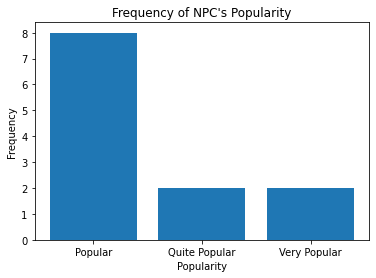

In [ ]:
plt.title("Frequency of NPC's Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.bar(res5["Popularity"],res5["Frequency"])
plt.show()